# Time

In [14]:
import pandas as pd

bytes_amnt = {
    'torch.float32': 4,
}

df = pd.read_csv('mtd_model_time_results.csv')

df['model_n_bytes_per_weights'] = df['model_dtype_str'].map(bytes_amnt)
df.drop(columns=['model_dtype_str'], inplace=True)

df['model_size_bytes'] = df['model_n_bytes_per_weights'] * df['model_n_weights']
df['model_size_mb'] = df['model_size_bytes'] / 1024 / 1024

df.drop(columns=['model_n_bytes_per_weights', 'model_n_weights', 'model_size_bytes'], inplace=True)

df_m = pd.melt(df, id_vars=['run_name', 'model_name', 'model_size_mb'], value_vars=['time_construct', 'time_obfuscate', 'time_deobfuscate', 'time_save', 'time_load'], var_name='action', value_name='time_seconds')

df_m['action'] = df_m['action'].str.replace('time_', '')

df_m=df_m[df_m['action'] != 'construct'].copy()

# df_m.drop(columns=['model_size_mb'], inplace=True)
df_m

,run_name,model_name,model_size_mb,action,time_seconds
1210,0,alexnet,233.081207,obfuscate,2.618465
1211,1,alexnet,233.081207,obfuscate,2.285254
1212,2,alexnet,233.081207,obfuscate,2.294456
1213,3,alexnet,233.081207,obfuscate,2.274610
1214,4,alexnet,233.081207,obfuscate,2.270321
...,...,...,...,...,...
6045,5,wide_resnet50_2,262.768707,load,0.044619
6046,6,wide_resnet50_2,262.768707,load,0.037262
6047,7,wide_resnet50_2,262.768707,load,0.037308
6048,8,wide_resnet50_2,262.768707,load,0.037098


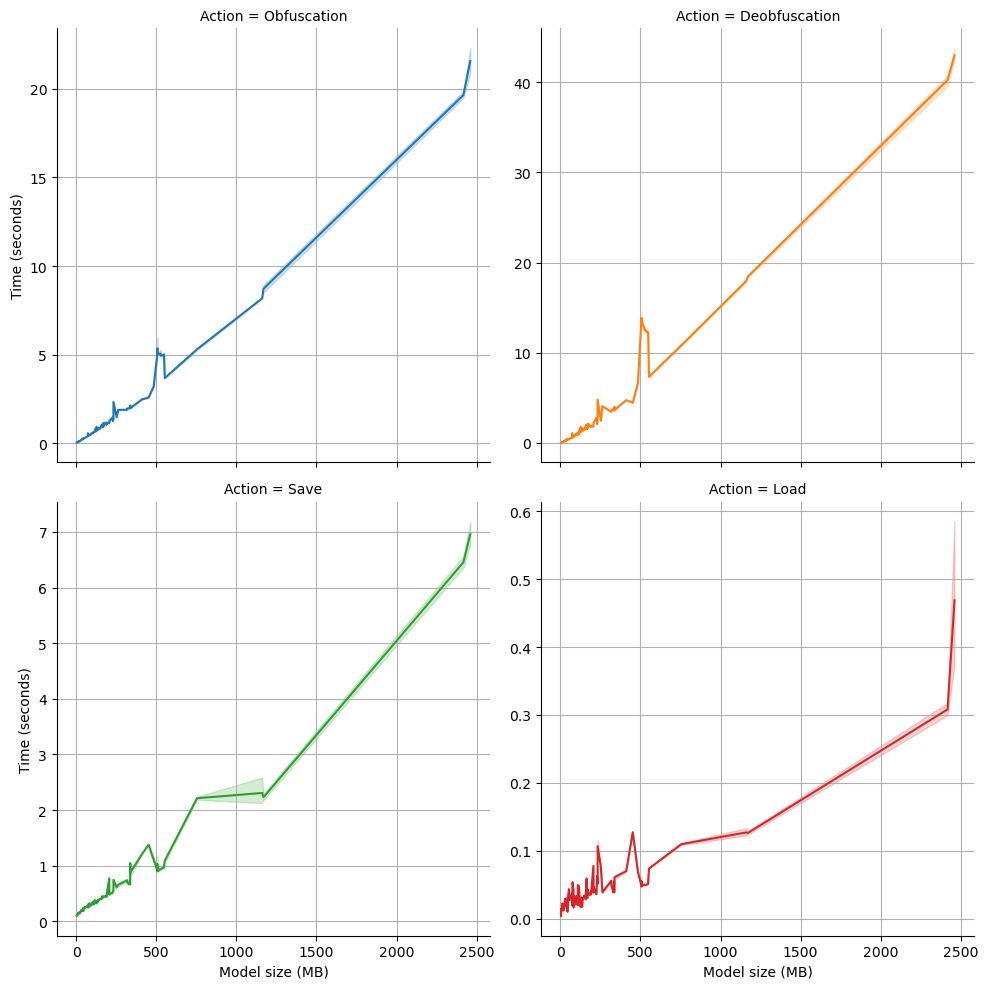

In [23]:
import seaborn as sns

val_map = {
    'action': {
        'construct': 'MTD Model Object Construction',
        'obfuscate': 'Obfuscation',
        'deobfuscate': 'Deobfuscation',
        'save': 'Save',
        'load': 'Load',
    }   
}

col_map = {
    'model_size_mb': 'Model size (MB)',
    'time_seconds': 'Time (seconds)',
    'action': 'Action',
}

df_m.replace(val_map, inplace=True)
df_m.rename(columns=col_map, inplace=True)

g = sns.relplot(data=df_m,
            x=col_map['model_size_mb'], y=col_map['time_seconds'],
            hue=col_map['action'], col=col_map['action'],
            col_wrap=2, kind='line',
            facet_kws={'sharey': False}
            )

# sns.move_legend(g, 'center', frameon=True, bbox_to_anchor=(0.46, 0.5))
g._legend.remove()

for ax in g.axes.flat:
    ax.grid(True)